# Census Data Collection

The American Census is a large endeavor, consisting of multiple surveys which vary from time series to geographical mappings. As a result, I took some time to go through some of what is there and (lightly) explore some of the data. This notebook explains current thoughts and processes, then performs API calls and processing to obtain a dashboard to use in my Moran's I post. 

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# data science
import pandas as pd
import missingno as msngo

# viz
import matplotlib.pyplot as plt

# geospatial
import geopandas as gpd

# module
import sys
sys.path.append("../src/")
import data, viz
from authentication import census_key

### Read in Data

In [3]:
gdf = gpd.read_file("../data/Census_Block_Groups_in_2010/")
display(gdf.head(1))

,OBJECTID,TRACT,BLKGRP,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,...,H0010003,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,001100,4,110010011004,722,687,610,29,2,41,...,10,BlockGroupPly_48,{706E35DA-3E58-44B3-92D4-A64756628066},None,None,None,None,0,0,"POLYGON ((-77.07295 38.95507, -77.07273 38.954..."


## Census Data Overview

An overview of the data available to us. 

### Choosing a Survey

The decennial census was last conducted in 2010, and as a result all of the measures that could obtain are dated. Due to this, I felt the American Community Survey may be more useful, as it is more frequent (1, 3 or 5 year spans) and still has all of the information I want for this dashboard. We can see a general overview of the survey at [ACS]:

>"[The ACS] started in 2005. It provides information on a wide range of social, economic, demographic, and housing characteristics. Topics covered include income, employment, health insurance, the age distribution, and education, among many others. The ACS replaces the old Census long form, which used to be distributed to a subset of households responding to the decennial Census. The ACS produces survey-based period estimates. For instance, the 5-year 2011-2015 estimates are based on data collected during all 5 years. They are not simply an aggregate of 1-year estimates, and overlapping 5-year estimates (e.g., 2008-2012 and 2011-2015) should not be compared. The ACS provides margins of error to accompany all estimates. Margins of error are smaller for estimates based on more years of data."

The usefulness of this data in particular is confirmed by other similar studies, such as the EIG's DCI work (explained below). 

[ACS]: https://www.census.gov/programs-surveys/acs/

### Variables of Interest and the Community Distress Index

The Economic Innovation Group serves as a great example overview of what we can do with the Census data we are pulling. The EIG focuses on a custom community distress index, which we could calculate or use as a general template for making our own meaningful aggregative community measures for analysis. The DCI exploration ([DCI]) studies data from the 5 Year ACS over the following seven DCI Variables:

- <b>No high school diploma</b>: Percent of the 25+ population without a high school diploma or equivalent.
- <b>Housing vacancy rate</b>: Percent of habitable housing that is unoccupied, excluding properties that are for seasonal, recreational, or occasional use.
- <b>Adults not working</b>: Percent of the prime-age population (25-64) not currently in work.
- <b>Poverty rate</b>: Percent of the population living under the poverty line.
- <b>Median income ratio</b>: Median household income as a percent of the state’s median household income (to account for cost of living differences across states).
- <b>Change in employment</b>: Percent change in the number of jobs.
- <b>Change in establishments</b>: Percent change in the number of business establishments.

The index is calculated by ranking units per each variable, averaging the ranks, and then normalizing the average to a percentile (see [DCI_methodology]). The communities are then grouped into quintiles and labeled (distressed, etc.). They also grouped study units (zip codes) into three population density categories (rural, suburban and urban) so that each is comprised of a third of the data used.  


[DCI]: https://eig.org/dci
[DCI_methodology]: https://eig.org/dci/methodology

### Geography Granularity

#### Overview of Available Geographies 

Other than choosing the survey and variables (with variables present being dependent on the selected survey), the final decision to make is what geography/scaling to take the data at. For example, one could take data at the County level, or break up counties as shown below into individual census "blocks".

<img src="./imgs/census_geo_1.png" width=500 height=700/>

The above image is not exhaustive. Following are some more geographies, although it is important to note that not all geographies are available in every survey. 

<img src="./imgs/census_geo_2.png" width=500 height=700/>

#### Past Geography Selection 

When I started to think about what geography to use when pulling data, I started with looking at what the DCI study used. 

From the [DCI_methodology], we saw usage of zip codes (ZCTA), with the methodology noting that
> "Since ZCTAs are static over each decade but zip codes may change, it is important to interpret the findings of the DCI as general trends for an approximate area rather than discrete developments within a clearly-defined set of lines."

I decided I want to go for a smaller-scale geography when calling data, and decided to explore options more (detailed in the following section).

You can view the geographical boundaries for the ACS at [dataset_list]. You first must locate the dataset you want, and then can click 'geographies' to get a list of the scales available for that data.      
    
    
[DCI_methodology]: https://eig.org/dci/methodology
[dataset_list]: https://api.census.gov/data.html

### Deciding on Data to Pull

To start, I needed to decide on a survey. I thought it would be useful to get as much data over time as we could to match our litter data, thus I started with the ACS 1 year survey. I then found geospatial boundary files from the Census 'TIGER' database ([TIGER]) and started to explore our options. 

I tried out many perspectives, noting that  
- 'County subdivision' is too broad.
- 'Core based statistical areas' are also too broad.
- 'Places' won't work; in DC is only one 'place', thus this essentially still at the county level as far as analysis is concerned.
    
As a result, I decided we should follow suit of the DCI and use ACS 5 year survey data, which has finer geographies. In addition, the ACS 5 data is more reliable/accurate in its estimates than the AC1 data. I found that the only remaining geographies that were available in both the ACS 5 year survey and the TIGER data:

- Tract.
- Block Group.

I ultimately chose the block group level. 

[TIGER]: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

#### Final Decisions and Notes on Possible Changes

So, to recap, for this initial data set call I have decided with the American Community 5 Year survey at the Block Group level from the year 2018.

### Feature Selection

With the geography and survey selection out of the way, I now look to identify some initial features of interest to ping for in our calls. There are of thousands of Census Bureau variables, but the selected survey (which was chosen for us by the geography selection as explained above) whittles down our options a good amount and makes this process a little easier for us. 

#### DCI Variables

To start, I take inspiration from the DCI ([DCI]) and identified variables that matched these closely. Notably, many variables can be further broken down (high school degree attainment per individual races, etc.), but I kept the variables high-level for now to keep the initial data and associated API calls simple. Here are some selected current variables again, with the approximate corresponding census variables/descriptions I was able to find listed under each. Note all variables were ensured to exist over both 2013 and 2018 data. 

- <b>No high school diploma</b>:
    - ```B15003_017E```: Estimated total with a regular high school diploma aged 25+.
    - divide by ```B01003_001E```- total population (used to calculate rates)
- <b>Housing vacancy rate</b>: Percent of habitable housing that is unoccupied, excluding properties that are for seasonal, recreational, or occasional use. This feature in particular was deemed a good indicator of DCI status. 
    - ```B25004_001E```: Total Estimate vacancy status.
    - ```B25004_006E```: Total estimate for seasonal, recreational or occasional usage.
    - dividing by ```B01003_001E```- total population (used to calculate rates)
- Median income
    - ```B19013_001E```: Median household income in the past 12 months (in 2017 inflation-adjusted dollars) 

[DCI]: https://eig.org/dci

#### Final Variable Selection 

In [4]:
# features to pull
variable2code = {
                 "population":"B01003_001E",
                 "hs_diploma":"B15003_017E",
                 "median_hh_income":"B19013_001E",
                 "vacancy":"B25004_001E", 
                 "reason_vacancy":"B25004_006E"
                }

# mapping from feature to column
code2variable = dict(zip(variable2code.values(), variable2code.keys()))

## Pulling Data

### Performing API Requests
Note for blockgroup calls I can only perform one state per call. 

In [5]:
census_df = data.run_api(census_key, "2018", list(gdf["GEOID"]), code2variable)

### Merging Dataframes 

In [6]:
# preparing merge key
census_df["GEOID"] = census_df["state"]+census_df["county"]+census_df["tract"]+census_df["block group"]
gdf["GEOID"] = gdf["GEOID"].astype(str)

In [7]:
df = census_df.merge(gdf[["GEOID", "geometry"]], on="GEOID", how="left")

### Missing Data

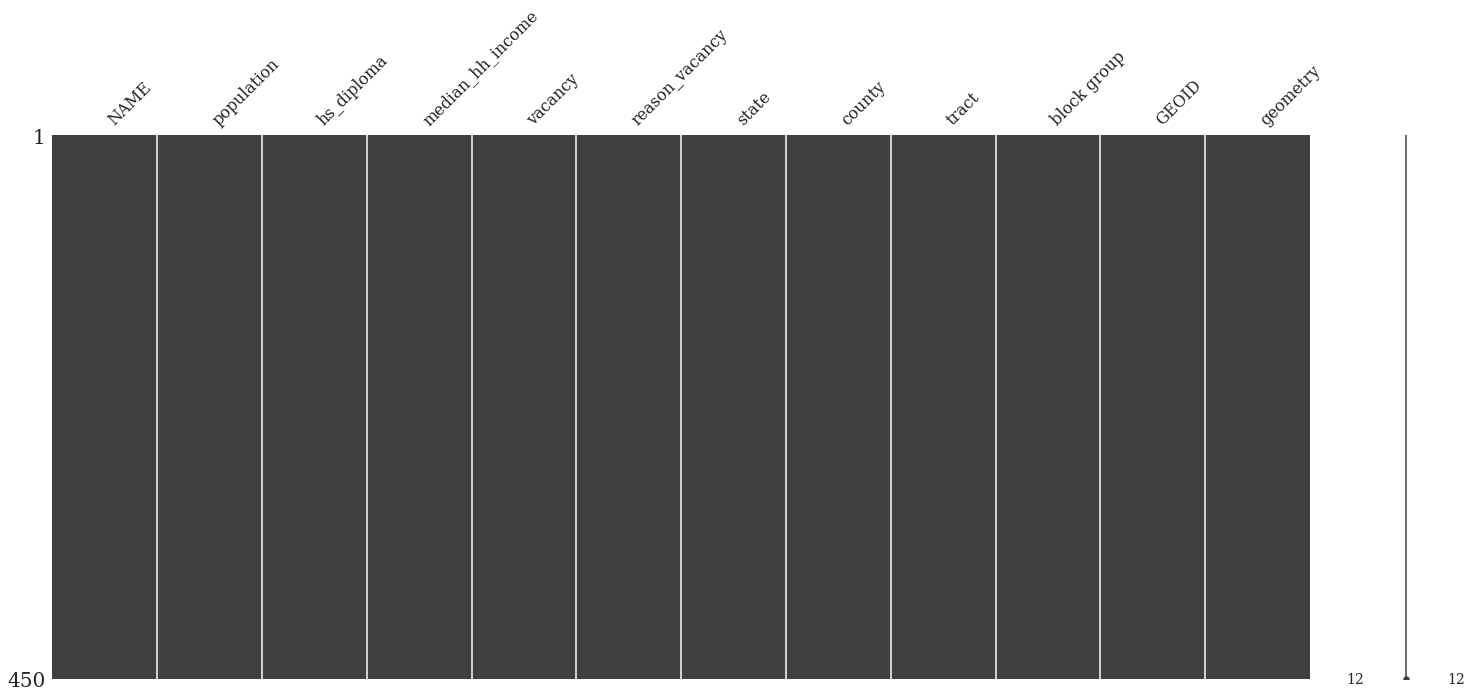

In [8]:
msngo.matrix(df)

### Basic Exploration

In [9]:
# Note I only am considering the Census features I called for here. 
feature_cols = list(variable2code.keys())
df[feature_cols] = df[feature_cols].astype(float)

In [10]:
df.describe()

,population,hs_diploma,median_hh_income,vacancy,reason_vacancy
count,450.000000,450.000000,4.500000e+02,450.000000,450.000000
mean,1521.106667,157.162222,-2.361062e+07,67.162222,7.755556
std,739.520836,156.206114,1.236081e+08,62.579218,20.652772
min,60.000000,0.000000,-6.666667e+08,0.000000,0.000000
25%,1001.000000,35.000000,4.808075e+04,23.250000,0.000000
50%,1421.000000,117.500000,8.923800e+04,51.500000,0.000000
75%,1847.000000,221.750000,1.267322e+05,98.750000,0.000000
max,6019.000000,831.000000,2.500010e+05,405.000000,214.000000


## Feature Engineering Census Data

In [11]:
make_rate = lambda x, y: round((x/y)*100, 2)

### % Population with High School Being Highest Education Level

In [12]:
df["hs_diploma_rate"] = make_rate(df["hs_diploma"], df["population"])

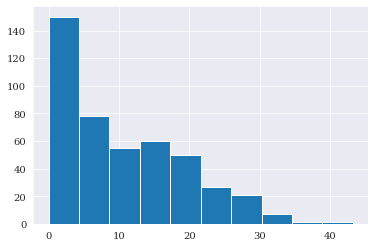

In [13]:
viz.quick_histogram(df, "hs_diploma_rate")

### "True" Housing Vacancy Rate 

Subtracting vacancies due to reasons such as "vacation home" from the total vacancy percentages. 

In [14]:
df["true_vacant"] = df["vacancy"] - df["reason_vacancy"]
df["vacancy_rate"] = make_rate(df["true_vacant"], df["population"])

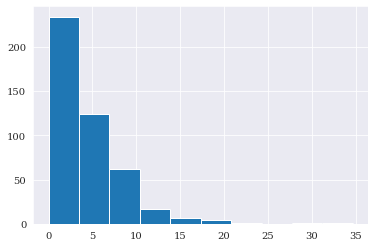

In [15]:
viz.quick_histogram(df, "vacancy_rate")

### Median HH Income

In [16]:
# for this simple exploration I'm just going to remove rows with negative values 
df = df[df["median_hh_income"]>0]

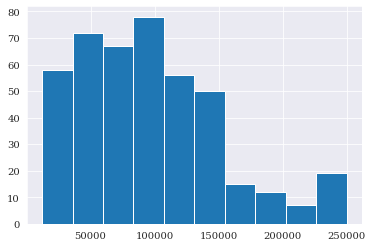

In [17]:
viz.quick_histogram(df, "median_hh_income")

### Custom DCI Segmentation

Taking inspiration from the DCI ranking scheme with some of the variables we have here to create our own DCI grouping. 

In [18]:
# selecting the variables to use in calculations and DCI class assignment
dci_vars2asc = {
                "hs_diploma_rate":True, # lower rates better ()
                "vacancy_rate":True, # lower rates better
                "median_hh_income":False # higher median income better
               }

In [19]:
# Calculating ranks in each variable (over data year).
for var, asc in dci_vars2asc.items():
    df[var+"_rank"] = df[var].rank(ascending=asc, method="dense")

In [20]:
# averaging the ranks per each site/year combination
rank_columns = [col+"_rank" for col in dci_vars2asc.keys()]
df["rank_mean"] = df[rank_columns].mean(axis=1)

In [21]:
df.reset_index(drop=True, inplace=True) # Removing the closest site outer index. 

In [22]:
# Note these are ranks, thus the lower the better.
df["dci"] = pd.qcut(df["rank_mean"], 4, labels=["Prosperous", "Decent", "At Risk", "Worst"])

In [23]:
df["dci"].unique() # remember lower is better since rank-based, so prosperous on left end

[Prosperous, At Risk, Worst, Decent]
Categories (4, object): [Prosperous < Decent < At Risk < Worst]

## Saving 

In [24]:
keep_features = ["geometry", "hs_diploma_rate", "vacancy_rate", "median_hh_income", "population", "dci"]
df[keep_features].to_csv("../data/processed.csv")